In [1]:
from neo4j import GraphDatabase, basic_auth
import pandas as pd

In [2]:
# launch neoj4 browser and start an instance of the database
driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=basic_auth("neo4j", "pokharel"))


In [3]:
cypher_query = '''
MATCH (a:Officer {name:$name})-[r:officer_of|intermediary_of|registered_address*..10]-(b)
RETURN b.name as name LIMIT 20
'''

### Github Example Query

In [4]:
with driver.session(database="neo4j") as session:
    results = session.read_transaction(
        lambda tx: tx.run(cypher_query,
                      name="Ross, Jr. - Wilbur Louis").data())
    
    for record in results:
        print(record['name'])

driver.close()

### More examples

In [5]:
cypher_query2 = '''
MATCH (o:Officer)-->(e:Entity)<-[:intermediary_of]-(i:Intermediary)
WHERE o.country_codes CONTAINS 'USA' and i.sourceID = 'Panama Papers'
RETURN e.jurisdiction_description AS jurisdiction, count(*) AS number
ORDER BY number DESC LIMIT 10
'''

In [6]:
with driver.session(database="neo4j") as session:
    results = session.run(cypher_query2)

    country = []
    val = []
    #print(results)
    for record in results:
        print(record)
        country.append(record.values()[0])
        val.append(record.values()[1])
        

driver.close()

In [7]:
import matplotlib.pyplot as plt

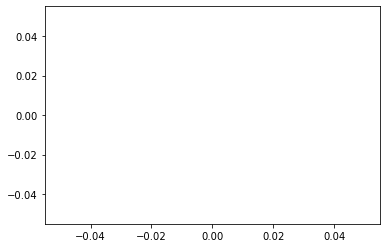

In [8]:
plt.plot(country,val)